In [78]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from torch.optim import SGD, Adam
from keras_preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import tqdm
import time
import os
import matplotlib.pyplot as plt
#get cwd
cwd = os.getcwd()
print(cwd)
#get upper of cwd
upper = os.path.dirname(cwd)
print(upper)

c:\Users\Alion\Desktop\csweb\Multi-triage\Code
c:\Users\Alion\Desktop\csweb\Multi-triage


  0%|          | 0/8 [00:00<?, ?it/s]

------------------------------------------------------------
DatasetName: roslyn,rawDataLen: 5062, newDataLen: 2539


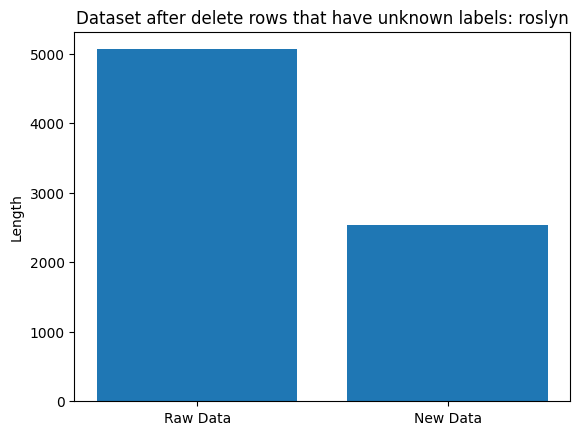

 12%|█▎        | 1/8 [00:00<00:02,  2.81it/s]

For roslyn AST column missing value rate: 0.7439936983064198
------------------------------------------------------------
DatasetName: aspnet,rawDataLen: 5059, newDataLen: 1518


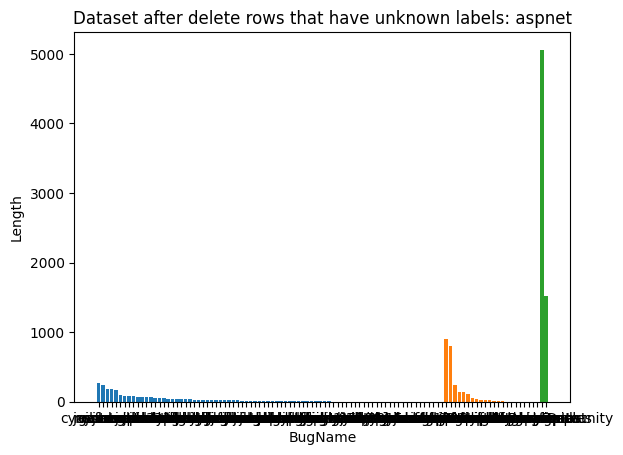

 25%|██▌       | 2/8 [00:00<00:03,  1.90it/s]

For aspnet AST column missing value rate: 0.9011857707509882
------------------------------------------------------------
DatasetName: efcore,rawDataLen: 6612, newDataLen: 1977


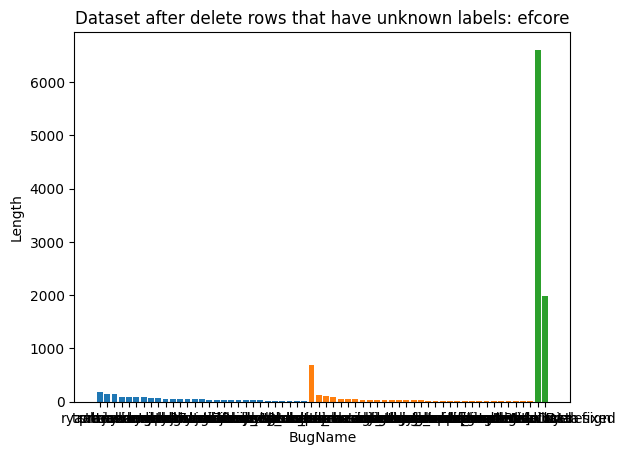

 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

For efcore AST column missing value rate: 0.7076378351036925
------------------------------------------------------------
DatasetName: powerShell,rawDataLen: 1767, newDataLen: 1084


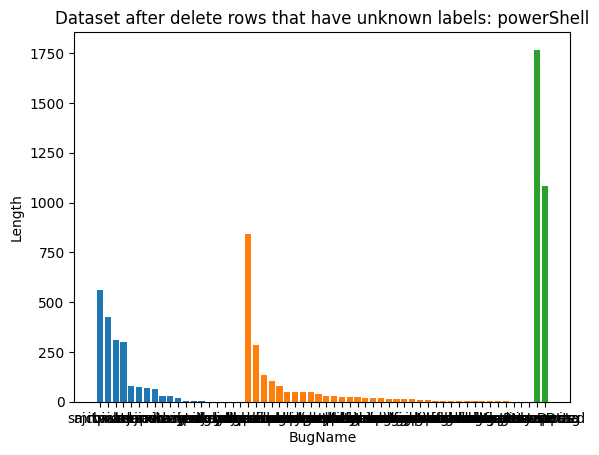

 50%|█████     | 4/8 [00:02<00:02,  1.79it/s]

For powerShell AST column missing value rate: 0.9206642066420664
------------------------------------------------------------
DatasetName: elasticSearch,rawDataLen: 5190, newDataLen: 1919


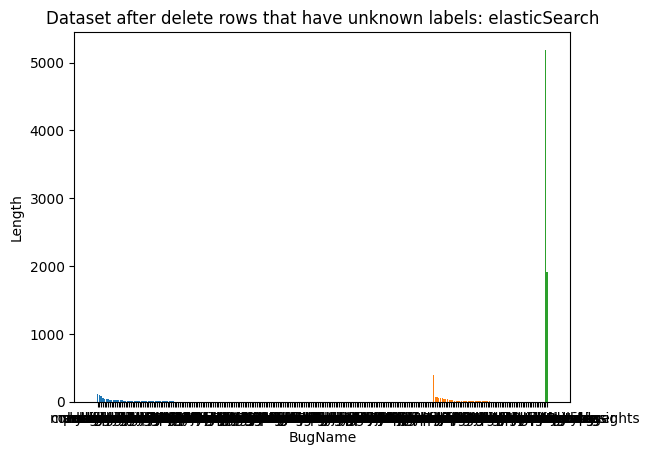

 62%|██████▎   | 5/8 [00:05<00:04,  1.39s/it]

For elasticSearch AST column missing value rate: 0.5539343408025013
------------------------------------------------------------
DatasetName: mixedReality,rawDataLen: 2294, newDataLen: 716


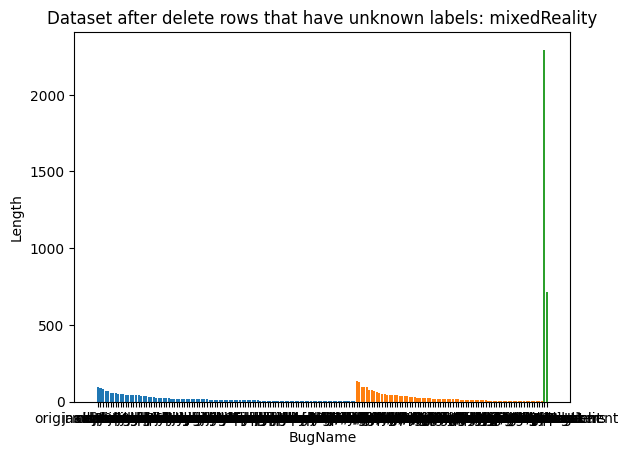

 75%|███████▌  | 6/8 [00:05<00:02,  1.14s/it]

For mixedReality AST column missing value rate: 0.9692737430167597
------------------------------------------------------------
DatasetName: monoGame,rawDataLen: 1008, newDataLen: 12


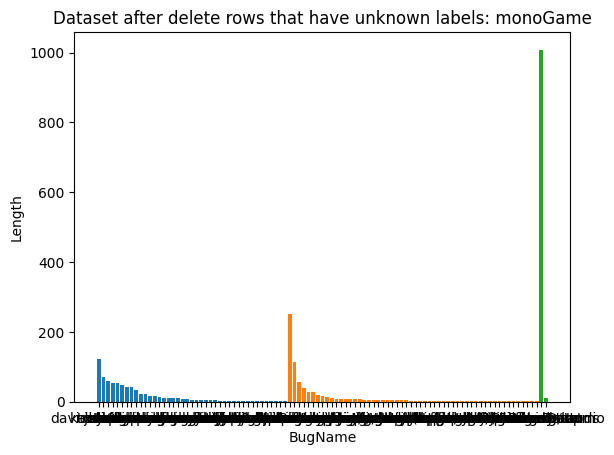

 88%|████████▊ | 7/8 [00:06<00:00,  1.12it/s]

For monoGame AST column missing value rate: 1.0
------------------------------------------------------------
DatasetName: realmJava,rawDataLen: 1160, newDataLen: 156


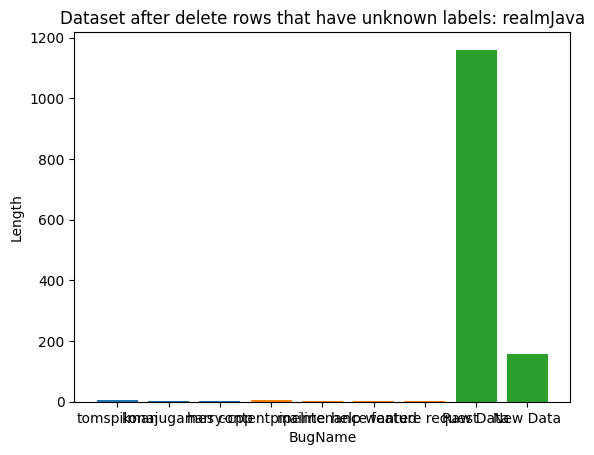

100%|██████████| 8/8 [00:06<00:00,  1.25it/s]

For realmJava AST column missing value rate: 0.6794871794871795


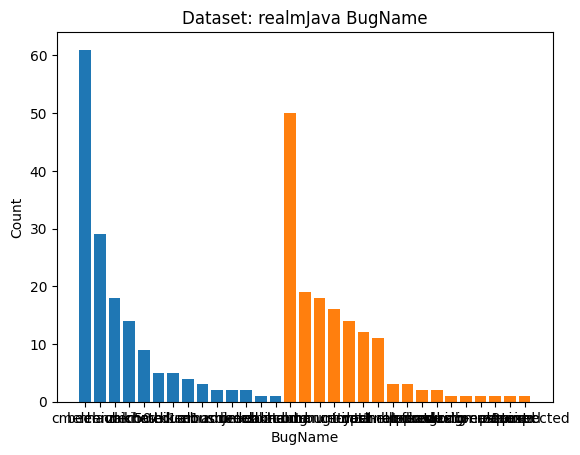

In [79]:
# dataset
paths = {
    'roslyn':f'{upper}\Data\\roslyn\IssueroslynWebScrap.csv', #roslyn
    'aspnet':f'{upper}\Data\\aspnet\\trainACU40.csv', #aspnet_train(80%)
    'efcore':f'{upper}\Data\efcore\IssueefcoreWebScrap.csv', #efcore
    'powerShell':f'{upper}\Data\powershell\C_uA_Train_without_doubleU.csv' ,#powershell_train (80%)
    'elasticSearch':f'{upper}\Data\elasticSearch\IssueelasticsearchWebScrap.csv', #elasticSearch
    'mixedReality':f'{upper}\Data\mixedRealityToolUnity\IssuemixedrealitytoolkitunityWebScrap.csv' ,#mixedRealityToolUnity
    'monoGame':f'{upper}\Data\monoGame\IssuemonogameWebScrap.csv', #monoGame
    'realmJava':f'{upper}\Data\\realmJava\IssuerealmjavaWebScrap.csv',# realmjava
    #nunit(to be processed from xml to csv)
    #r'..\Data\nunit\IssuenunitWebScrap.csv' #nunit
    #rxjava(to be processed from xml to csv)
    #r'..\Data\rxjava\IssuerxjavaWebScrap.csv' #rxjava
}

#获取前5项数据的第二个tensor
#如果AST为空，第二个tensor的值的只有一个10
# print(train_dataset[0][0][1], train_dataset[1][0][1], train_dataset[2][0][1], train_dataset[3][0][1], train_dataset[4][0][1])
# #遍历数据集，统计第二个tensor的值里面只有一个10的数量
# count = 0
# for i in range(len(train_dataset)):
#     if train_dataset[i][0][1][0] == 10:
#         count += 1
# print(count, len(train_dataset))
# has_AST = 1 - count/len(train_dataset)
# print(has_AST)


for datasetName,path in tqdm.tqdm(paths.items()):
    print('-'*60)
    data = pd.read_csv(path)
    rawDataLen = len(data)
    #做以下几个处理： 
    #1.将FixedByID为unknown的行去除,将Name为unknown的行去除 
    data = data[data['FixedByID'] != 'unknown']
    data = data[data['Name'] != 'unknown']
    newDataLen = len(data)
    print(f'DatasetName: {datasetName},rawDataLen: {rawDataLen}, newDataLen: {newDataLen}')
    #为新数据集生成去除空标签后与去除空标签前的对比图
    plt.bar(['Raw Data', 'New Data'], [rawDataLen, newDataLen])
    plt.title(f'Dataset after delete rows that have unknown labels: {datasetName}')
    plt.ylabel('Length')
    # plt.show()

    #2.可视化FixedByID列和Name列的分布(先提取字符串中的标签，再统计标签的数量排列成条形图)
    #FixedByID
    fixedByID = data['FixedByID']
    fixedByID = fixedByID.apply(lambda x: x.split('|')[0])
    # print(fixedByID.value_counts())
    plt.bar(fixedByID.value_counts().index, fixedByID.value_counts().values)
    plt.title(f'Dataset: {datasetName} FixedByID')
    plt.ylabel('Count')
    plt.xlabel('FixedByID')
    # plt.show()
    #BugName
    bugName = data['Name']
    bugName = bugName.apply(lambda x: str(x))
    bugName = bugName.apply(lambda x: x.split('|')[0])
    # print(bugName.value_counts())
    plt.bar(bugName.value_counts().index, bugName.value_counts().values)
    plt.title(f'Dataset: {datasetName} BugName')
    plt.ylabel('Count')
    plt.xlabel('BugName')
    # plt.show()

    #3.输出AST列的空值占比(NaN为空) 
    print(f'For {datasetName} AST column missing value rate: {data["AST"].isnull().sum()/len(data)}')

# EDA

In [80]:

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
def one_hot_to_indices(one_hot_array):
    indices = np.argmax(one_hot_array, axis=1)
    return indices

# 获取所有的标签
y_dev_labels = train_dataset.y_dev
y_btype_labels = train_dataset.y_btype

# print('y_dev_labels:', y_dev_labels[:1])
# print('y_btype_labels:', y_btype_labels[:1])
# print('len(y_dev_labels[0]):', len(y_dev_labels[0])) # number of developer types
# print('len(y_btype_labels[0]):', len(y_btype_labels[0])) #  number of bug types

# 使用你的独热编码数组调用函数
indices_dev = one_hot_to_indices(y_dev_labels.numpy())
# print(indices_dev)
indices_btype = one_hot_to_indices(y_btype_labels.numpy())
# print(indices_btype)

dev_idx2label = {i: idx2label[0][i] for i in range(len(idx2label[0]))}
btype_idx2label = {i: idx2label[1][i] for i in range(len(idx2label[1]))}

# 计算每个标签的出现次数
dev_label_counts = Counter(indices_dev)
btype_label_counts = Counter(indices_btype)

# 获取排序的键值对
dev_label_counts_sorted = dev_label_counts.most_common()
btype_label_counts_sorted = btype_label_counts.most_common()

# 打印出现次数排行
print('Developer Type Label Counts:')
for label, count in dev_label_counts_sorted:
    print(f'{dev_idx2label[label]}: {count}')

print('\nBug Type Label Counts:')
for label, count in btype_label_counts_sorted:
    print(f'{btype_idx2label[label]}: {count}')

# 画出直方图
plt.figure(figsize=(10, 5))
plt.bar(range(len(dev_label_counts)), [count for label, count in dev_label_counts_sorted])
plt.title('Developer Type Label Distribution of dataset {}'.format(train_path.split('/')[-1].split('.')[0]))
plt.xlabel('Label_ID')
plt.ylabel('Count')
# plt.show()
# 保存matplotlib图像
plt.savefig('EDA_result/Developer Type Label Distribution of dataset {}'.format(train_path.split('/')[-1].split('.')[0]))

plt.figure(figsize=(10, 5))
plt.bar(range(len(btype_label_counts)), [count for label, count in btype_label_counts_sorted])
plt.title('Bug Type Label Distribution of dataset {}'.format(train_path.split('/')[-1].split('.')[0]))
plt.xlabel('Label_ID')
plt.ylabel('Count')
# plt.show()
# 保存matplotlib图像
plt.savefig('EDA_result/Bug Type Label Distribution of dataset {}'.format(train_path.split('/')[-1].split('.')[0]))

AttributeError: 'DataFrame' object has no attribute 'y_dev'